# Project 6
Outline:
 1. Look at distribution of data
 2. Fit initial model & check metrics
 3. Check Assumptions
 4. Look at autocorrelation
 5. Use seasonality in model
 6. Check final model with seasons metrics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set_theme()

## 1. Data Exploration

In [3]:
hydro = pd.read_csv("data/RRCA_baseflow.csv")
hydro.head()

,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed
0,710732,144,1086190,14476800,0.59,18.99,0.0,0.145161
1,710763,144,1086190,14476800,0.97,29.63,0.0,0.445161
2,710791,144,1086190,14476800,1.34,29.63,0.0,1.332203
3,710822,144,1086190,14476800,1.79,29.63,0.0,2.932203
4,710852,144,1086190,14476800,8.23,29.63,0.0,3.728689


In [5]:
# fix date variable, add days var representing days since 1900-01-01
hydro['days'] = hydro.Date - 693963
hydro['Date'] = pd.to_datetime(hydro['days'] ,origin='1900-01-01', unit='D')
hydro.head()

,Date,Segment_id,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,Observed,days
0,1945-11-30,144,1086190,14476800,0.59,18.99,0.0,0.145161,16769
1,1945-12-31,144,1086190,14476800,0.97,29.63,0.0,0.445161,16800
2,1946-01-28,144,1086190,14476800,1.34,29.63,0.0,1.332203,16828
3,1946-02-28,144,1086190,14476800,1.79,29.63,0.0,2.932203,16859
4,1946-03-30,144,1086190,14476800,8.23,29.63,0.0,3.728689,16889


<AxesSubplot: xlabel='Date', ylabel='Observed'>

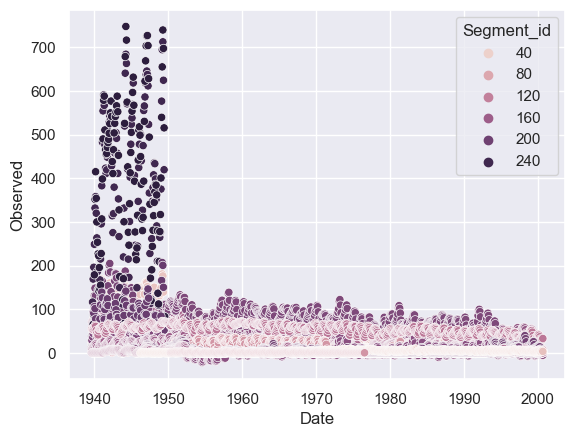

In [9]:
# look at target variable over time, split by segment_id
sns.scatterplot(hydro, x='Date', y='Observed', hue='Segment_id')

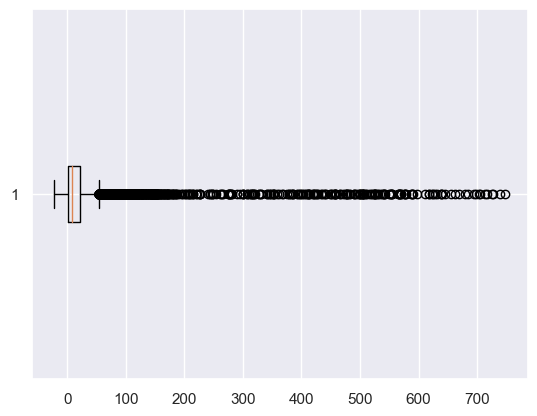

In [124]:
# look at outliers
plt.boxplot(hydro["Observed"], vert=False)
plt.show()

<AxesSubplot: xlabel='Segment_id', ylabel='Observed'>

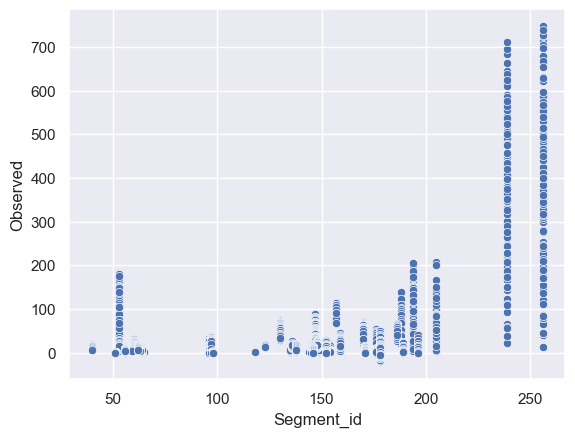

In [121]:
# higher segment_id's correlate to the first chunk that causes the skew?
sns.scatterplot(hydro, x='Segment_id', y='Observed')

In [123]:
# find what the two outlier groups are
hydro.loc[hydro.Segment_id > 210].Segment_id.unique()

array([239, 256])

In [126]:
# look at range of dates for those two segments (seem to be old and not relevant)
hydro.loc[(hydro.Segment_id == 239) | (hydro.Segment_id == 256)].Date.describe()

/var/folders/7r/1k5_crzn4pg__hyvxlp5zk_80000gn/T/ipykernel_5399/3746673552.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  hydro.loc[(hydro.Segment_id == 239) | (hydro.Segment_id == 256)].Date.describe()


count                     238
unique                    119
top       1939-09-30 00:00:00
freq                        2
first     1939-09-30 00:00:00
last      1949-07-31 00:00:00
Name: Date, dtype: object

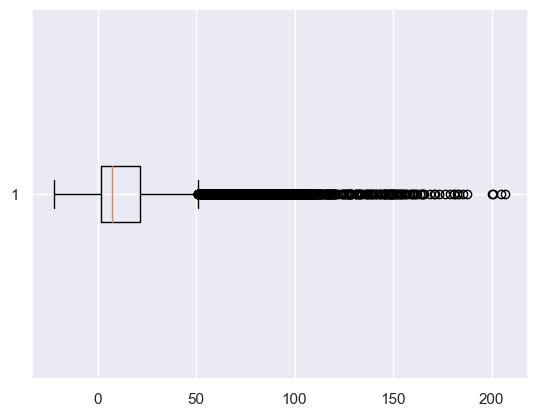

In [125]:
# look at outliers
plt.boxplot(hydro.loc[hydro.Segment_id < 220].Observed, vert=False)
plt.show()

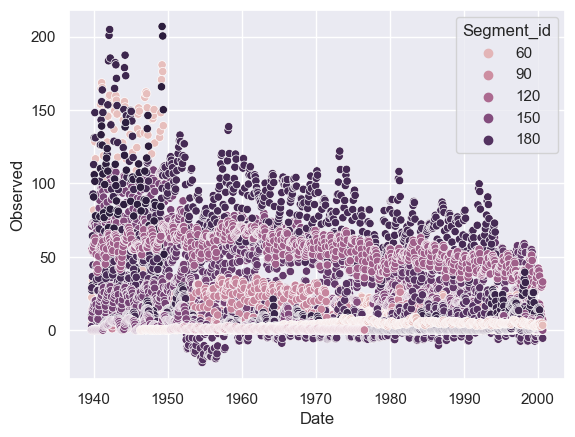

In [129]:
# look at baseflow over time when bad segs removed
hydro_2 = hydro.loc[hydro.Segment_id < 220]
sns.scatterplot(hydro_2, x='Date', y='Observed', hue='Segment_id')
plt.show()


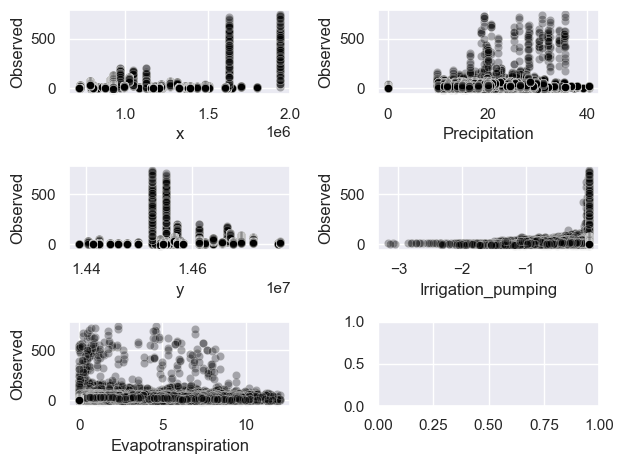

In [130]:
# check out explanatory variables in comparison to response variable when segments 239 and 256 aren't removed
fig, axs = plt.subplots(3, 2)
sns.scatterplot(data=hydro, x='x', y='Observed', ax=axs[0,0], alpha=0.3, color='black')
sns.scatterplot(data=hydro, x='y', y='Observed', ax=axs[1,0], alpha=0.3, color='black')
sns.scatterplot(data=hydro, x='Evapotranspiration', y='Observed', ax=axs[2,0], alpha=0.3, color='black')
sns.scatterplot(data=hydro, x='Precipitation', y='Observed', ax=axs[0,1], alpha=0.3, color='black')
sns.scatterplot(data=hydro, x='Irrigation_pumping', y='Observed', ax=axs[1,1], alpha=0.3, color='black')


plt.tight_layout()
plt.show()


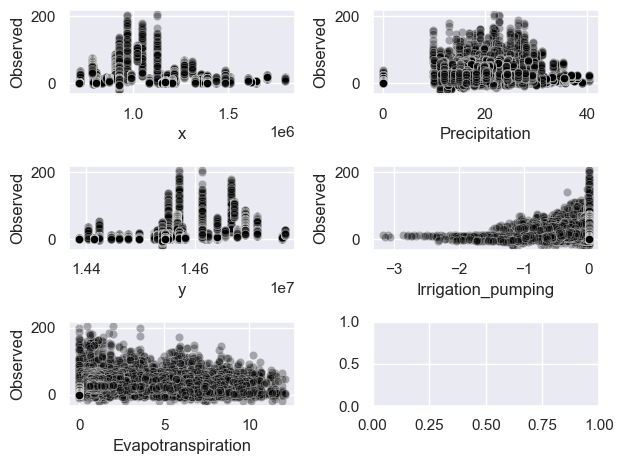

In [131]:
# check out vars when 239 and 256 are removed
fig, axs = plt.subplots(3, 2)
sns.scatterplot(data=hydro_2, x='x', y='Observed', ax=axs[0,0], alpha=0.3, color='black')
sns.scatterplot(data=hydro_2, x='y', y='Observed', ax=axs[1,0], alpha=0.3, color='black')
sns.scatterplot(data=hydro_2, x='Evapotranspiration', y='Observed', ax=axs[2,0], alpha=0.3, color='black')
sns.scatterplot(data=hydro_2, x='Precipitation', y='Observed', ax=axs[0,1], alpha=0.3, color='black')
sns.scatterplot(data=hydro_2, x='Irrigation_pumping', y='Observed', ax=axs[1,1], alpha=0.3, color='black')


plt.tight_layout()
plt.show()

## 2. Model Fitting

In [139]:
# model with all data
X = hydro_2.drop(columns=['Date', 'Observed'])
X = pd.get_dummies(X, columns=['Segment_id', 'xy'], drop_first=True)
y = hydro_2['Observed']

results = sm.OLS(y, sm.add_constant(X)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Observed   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     1967.
Date:                Wed, 22 Mar 2023   Prob (F-statistic):               0.00
Time:                        00:43:46   Log-Likelihood:                -56806.
No. Observations:               15353   AIC:                         1.137e+05
Df Residuals:                   15305   BIC:                         1.141e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.0482 

In [137]:
# make sure vars are all significant
results.pvalues.sort_values(ascending=False)

Segment_id_62           0.003291
xy_1603630, 14556000    0.003291
xy_1360750, 14529600    0.001746
xy_1191790, 14767200    0.000059
Segment_id_136          0.000059
                          ...   
Segment_id_194          0.000000
y                       0.000000
xy_1049230, 14666880    0.000000
xy_1128430, 14614080    0.000000
xy_991150, 14714400     0.000000
Length: 88, dtype: float64

All p-values are significant, but it might make it a little cleaner and more interpretable to cut out things that might be getting double counted and have strong multicollinearity, like our xy dummy variables and our segments.

In [140]:
# model without x, y, or segments
X = hydro_2.drop(columns=['Date', 'Observed', 'Segment_id', 'x', 'y'])
X = pd.get_dummies(X, columns=['xy'], drop_first=True)
y = hydro_2['Observed']

results = sm.OLS(y, sm.add_constant(X)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Observed   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     1967.
Date:                Wed, 22 Mar 2023   Prob (F-statistic):               0.00
Time:                        00:43:59   Log-Likelihood:                -56806.
No. Observations:               15353   AIC:                         1.137e+05
Df Residuals:                   15305   BIC:                         1.141e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   94.4810 

In [142]:
# make sure all vars are significant
results.pvalues.sort_values(ascending=False).head()

xy_927790, 14550720     1.591077e-19
Irrigation_pumping      2.089760e-27
xy_970030, 14571840     5.801795e-28
xy_1049230, 14666880    6.677795e-32
Precipitation           4.069223e-37
dtype: float64

# TRASH BELOW HERE
Below here is a bunch of work we did before realizing that our results were going to be super weird and not as interpretable if we included the data from segments 239 and 256, because they accounted for all of the baseflow above 220ish, and observations only ran from 1939-1949.

Also we started doing a bunch of stuff outside of the scope of this project that we didn't fully understand (time-series and engineering lag features) so we're just doing the basics here.

## 2. Initial Model
Here we will fit an initial model and see if it meets the linear model assumptions

In [18]:
# since x and y have to do with a discrete location on the river, we will also use them as a dummy variable,
# but we'll keep the separate x and y to predict as quantitative and see if it works
hydro['xy'] = hydro.x.astype(str) + ', ' + hydro.y.astype(str)
X = pd.get_dummies(hydro, columns=["Segment_id", "xy"], drop_first=True).drop(columns=["Date", "Observed"])
X = sm.add_constant(X)
y = hydro["Observed"]
display(X.head())
display(y.head())

,const,x,y,Evapotranspiration,Precipitation,Irrigation_pumping,days,Segment_id_51,Segment_id_53,Segment_id_55,...,"xy_790510, 14424000","xy_806350, 14550720","xy_838030, 14556000","xy_859150, 14714400","xy_874990, 14556000","xy_906670, 14693280","xy_927790, 14540160","xy_927790, 14550720","xy_970030, 14571840","xy_991150, 14714400"
0,1.0,1086190,14476800,0.59,18.99,0.0,16769,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1086190,14476800,0.97,29.63,0.0,16800,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1086190,14476800,1.34,29.63,0.0,16828,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,1086190,14476800,1.79,29.63,0.0,16859,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1086190,14476800,8.23,29.63,0.0,16889,0,0,0,...,0,0,0,0,0,0,0,0,0,0


0    0.145161
1    0.445161
2    1.332203
3    2.932203
4    3.728689
Name: Observed, dtype: float64

In [45]:
model_0 = sm.OLS(y, X)
results_0 = model_0.fit()
print(results_0.summary())


                            OLS Regression Results                            
Dep. Variable:               Observed   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     1411.
Date:                Tue, 21 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:08:44   Log-Likelihood:                -71739.
No. Observations:               15591   AIC:                         1.436e+05
Df Residuals:                   15541   BIC:                         1.440e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2514 

In [48]:
# try dropping x & y since we made them categorical
X = X.drop(columns=['x', 'y'])

model_1 = sm.OLS(y, X)
results_1 = model_1.fit()
print(results_1.summary())

                            OLS Regression Results                            
Dep. Variable:               Observed   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     1411.
Date:                Tue, 21 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:10:44   Log-Likelihood:                -71739.
No. Observations:               15591   AIC:                         1.436e+05
Df Residuals:                   15541   BIC:                         1.440e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   38.0198 

In [49]:
# check assumptions (many use the errors)
y_pred = results_1.predict(X)
errors = y - y_pred

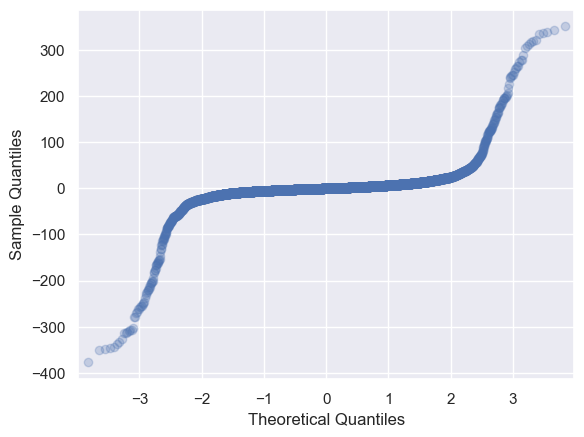

In [50]:
# normality of errors
sm.qqplot(errors, alpha=0.25)
plt.show()

<AxesSubplot: >

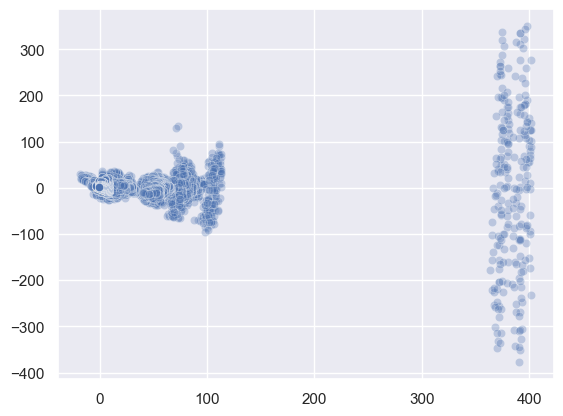

In [57]:
# check error vs pred
sns.scatterplot(x=y_pred, y=errors, alpha=0.3)

## 3. Fix Violated Assumptions
Now we attempt to fix the violated assumptions, and will recheck the model for violations and check it's metrics

## 4. Time-Series Feature Engineering
Here we will attempt to improve our model by looking at whether autocorrelation exists, and if it does we will create lag features.

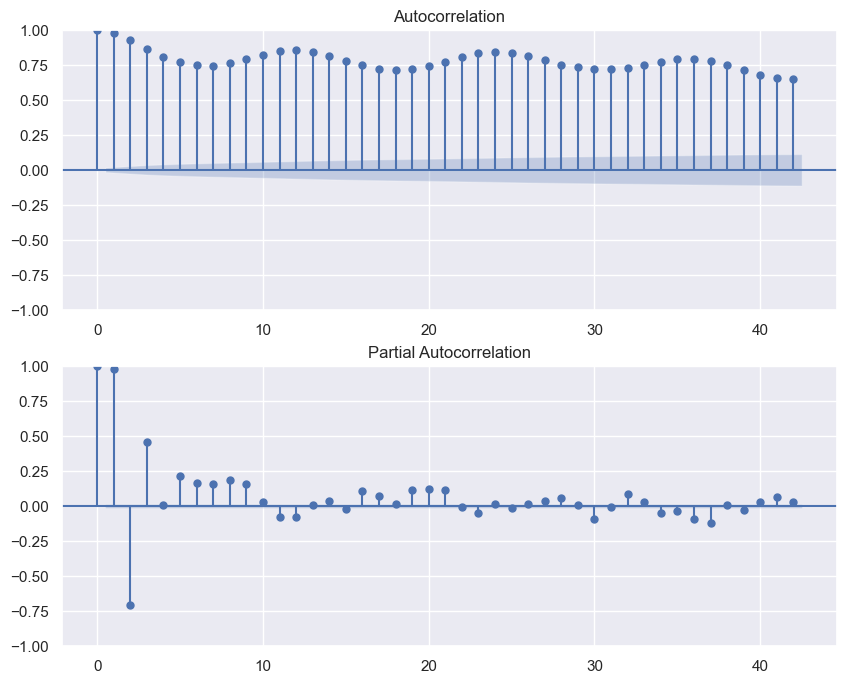

In [53]:
# look at autocorrelation
fig, axes = plt.subplots(2, 1, figsize=(10,8))
plot_acf(y, ax=axes[0])
plot_pacf(y, ax=axes[1])
plt.show()

This strongly suggests that the observed baseflow is highly influenced by previous measurements of observed baseflow

In [ ]:
# add season feature to account for time


## 5. Final Model and Conclusions

In [59]:
# standardize to interpret coefficients
quant_cols = ['Evapotranspiration', 'Precipitation', 'Irrigation_pumping']
for col in quant_cols:
    X[col] = (X[col] - X[col].mean()) / X[col].std()

In [62]:
model_3 = sm.OLS(y, X)
results_3 = model_3.fit()
print(results_3.summary())

                            OLS Regression Results                            
Dep. Variable:               Observed   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     1411.
Date:                Tue, 21 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:28:02   Log-Likelihood:                -71739.
No. Observations:               15591   AIC:                         1.436e+05
Df Residuals:                   15541   BIC:                         1.440e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   43.7536 

In [70]:
# check out how the quantitative variables affect the model
results_3.params[quant_cols].sort_values(ascending=False)

Precipitation         6.120623
Irrigation_pumping    0.959896
Evapotranspiration   -2.803519
dtype: float64

In [73]:
# check out the most extreme coefficients of all variables
print(results_3.params.sort_values(ascending=False).head(10))
print()
print(results_3.params.sort_values().head(10))

Segment_id_256          174.287227
xy_1941550, 14524320    174.287227
xy_1630030, 14550720    164.815599
Segment_id_239          164.815599
xy_1049230, 14666880     50.154619
Segment_id_157           49.815308
const                    43.753631
Segment_id_194           32.774946
xy_970030, 14571840      32.774946
xy_927790, 14550720      20.298808
dtype: float64

xy_991150, 14714400    -36.035163
xy_1798990, 14561280   -26.435640
Segment_id_171         -19.760038
xy_1186510, 14761920   -18.857493
Segment_id_118         -18.857493
xy_1133710, 14619360   -18.201661
Segment_id_55          -18.201661
Segment_id_63          -18.149285
xy_1619470, 14556000   -18.149285
Segment_id_152         -17.632549
dtype: float64


In [77]:
# try removing combined xy since it's literally the same as Segment_id (almost exactly)
X_new = hydro.drop(columns=['xy', 'x', 'y', 'Date', 'Observed'])
for col in quant_cols:
    X_new[col] = (X_new[col] - X_new[col].mean()) / X_new[col].std()

In [79]:
model_4 = sm.OLS(y, sm.add_constant(X_new))
results_4 = model_4.fit()
print(results_4.summary())

                            OLS Regression Results                            
Dep. Variable:               Observed   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     948.8
Date:                Tue, 21 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:54:00   Log-Likelihood:                -82886.
No. Observations:               15591   AIC:                         1.658e+05
Df Residuals:                   15585   BIC:                         1.658e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 21.1246      2

In [87]:
# terrible R^2, lets try throwing xy or x and y back in
X_new = hydro.drop(columns=['x', 'y', 'Date', 'Observed'])
for col in quant_cols:
    X_new[col] = (X_new[col] - X_new[col].mean()) / X_new[col].std()

model_5 = sm.OLS(y, sm.add_constant(pd.get_dummies(X_new, columns=['xy'], drop_first=True)))
results_5 = model_5.fit()
print(results_5.summary())

                            OLS Regression Results                            
Dep. Variable:               Observed   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     1411.
Date:                Tue, 21 Mar 2023   Prob (F-statistic):               0.00
Time:                        22:59:05   Log-Likelihood:                -71739.
No. Observations:               15591   AIC:                         1.436e+05
Df Residuals:                   15541   BIC:                         1.440e+05
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -47.3339 

In [92]:
# arguably best model since least vars and most r2, so check out extreme coefficients
print(results_5.params.sort_values(ascending=False).head(20))
print()
print(results_5.params.sort_values().head(20))

xy_1941550, 14524320    209.909581
xy_1630030, 14550720    206.223321
xy_1049230, 14666880    107.795682
xy_1798990, 14561280     28.753082
xy_991150, 14714400      21.605900
xy_1144270, 14677440     17.504568
xy_1154830, 14413440     17.406069
xy_1170670, 14582400     15.369939
xy_874990, 14556000      14.886682
Precipitation             6.120623
xy_1133710, 14619360      5.323345
xy_1603630, 14556000      4.492199
xy_838030, 14556000       3.201186
Irrigation_pumping        0.959896
Segment_id                0.897470
days                     -0.000333
xy_1645870, 14566560     -0.861330
xy_1619470, 14556000     -1.751666
Evapotranspiration       -2.803519
xy_785230, 14566560      -6.684015
dtype: float64

xy_1482190, 14577120   -108.183391
xy_1392430, 14571840   -105.140769
xy_927790, 14540160     -97.740084
xy_1508590, 14524320    -95.456681
xy_1381870, 14460960    -88.583219
xy_790510, 14424000     -87.438429
xy_1138990, 14497920    -79.313431
xy_1181230, 14656320    -75.655331
xy_1

In [90]:
# check if it's the same with x and y and not xy
X_new = hydro.drop(columns=['xy', 'Date', 'Observed'])

quant_cols.append('x')
quant_cols.append('y')

for col in quant_cols:
    X_new[col] = (X_new[col] - X_new[col].mean()) / X_new[col].std()

model_6 = sm.OLS(y, sm.add_constant(X_new))
results_6 = model_6.fit()
print(results_6.summary())

                            OLS Regression Results                            
Dep. Variable:               Observed   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     686.2
Date:                Tue, 21 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:01:37   Log-Likelihood:                -82863.
No. Observations:               15591   AIC:                         1.657e+05
Df Residuals:                   15583   BIC:                         1.658e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 21.8841      2

In [95]:
X_new = hydro.drop(columns=['x', 'y', 'Date', 'Observed', 'xy'])
X_new = pd.get_dummies(X_new, columns=['Segment_id'], drop_first=True)
model_7 = sm.OLS(y, sm.add_constant(pd.get_dummies(X_new)))
results_7 = model_7.fit()
print(results_7.summary())

                            OLS Regression Results                            
Dep. Variable:               Observed   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     1447.
Date:                Tue, 21 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:20:04   Log-Likelihood:                -72122.
No. Observations:               15591   AIC:                         1.443e+05
Df Residuals:                   15545   BIC:                         1.447e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 13.4406      2

Conclusion: Using dummied out segments or dummied out xy combos are huge in getting a higher adjusted r2

In [98]:
X_final = hydro.drop(columns=['x', 'y', 'Date', 'Observed', 'Segment_id', 'days'])
X_final = pd.get_dummies(X_final, columns=['xy'], drop_first=True)

final_model = sm.OLS(y, sm.add_constant(pd.get_dummies(X_final)))
final_results = final_model.fit()
print(final_results.summary())

                            OLS Regression Results                            
Dep. Variable:               Observed   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     1433.
Date:                Tue, 21 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:42:09   Log-Likelihood:                -71777.
No. Observations:               15591   AIC:                         1.437e+05
Df Residuals:                   15542   BIC:                         1.440e+05
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   81.6575 